# Installation

In [2]:
!wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
!tar -xjf LJSpeech-1.1.tar.bz2

--2021-11-28 14:22:21--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 174.138.79.61
Connecting to data.keithito.com (data.keithito.com)|174.138.79.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [application/octet-stream]
Saving to: ‘LJSpeech-1.1.tar.bz2’

LJSpeech-1.1.tar.bz 100%[===================>]   2.56G  43.3MB/s    in 62s     

2021-11-28 14:23:23 (42.4 MB/s) - ‘LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [9]:
%%bash
pip install googledrivedownloader
pip install wandb

     |████████████████████████████████| 1.7 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 140 kB 34.7 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 30.1 MB/s eta 0:00:01
     |████████████████████████████████| 180 kB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.0 MB/s  eta 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=fb31f9f0266bb640f44c4f7311c4750cb62fa1ad983f90e298373ac697d6d49d
  Stored in directory: /root/.cache/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=bbe97ce9f39496c3163463e66140d6122bb6db6fadf9e513eb78cef3431fdd24
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a592

# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from tts.collate_fn import Batch, LJSpeechCollator
from tts.datasets.ljspeech import LJSpeechDataset
from tts.melspec import MelSpectrogram, MelSpectrogramConfig
from tts.model import Vocoder, GraphemeAligner
from tts.model.fastspeech import FastSpeech
from tts.model.config import FSConfig
from tts.trainer.simple_trainer import train_epoch
from tts.loss.fast_speech import FastSpeechLossWrapper

device = 'cuda:0'

In [3]:
from itertools import islice, repeat
from torch.utils.data import DataLoader
import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
from IPython import display
import wandb
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

In [26]:
dataset = LJSpeechDataset('.')
featurizer = MelSpectrogram(MelSpectrogramConfig()).to(device)

dataloader = DataLoader(dataset, batch_size=4, collate_fn=LJSpeechCollator(melspec=featurizer))

# Aligner

In [27]:
aligner = GraphemeAligner().to(device)

In [55]:
wandb.init(
    project='FastSpeech'
)

In [36]:
train_config = {
    'use_wandb': True,
    'grad_accum_steps': 1,
    'len_epoch': 100_000,
    'device': device
}

In [37]:
config = FSConfig(hidden_size=384, encoder_num_heads=6, encoder_num_layers=6)
model = FastSpeech(config)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = ExponentialLR(optimizer, 0.99)
loss = FastSpeechLossWrapper()

Process wandb_internal:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/wandb/sdk/internal/internal.py", line 153, in wandb_internal
    thread.join()
  File "/opt/conda/lib/python3.7/threading.py", line 1044, in join
    self._wait_for_tstate_lock()
  File "/opt/conda/lib/python3.7/threading.py", line 1060, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


In [40]:
import numpy as np
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [41]:
count_parameters(model)

50448721

In [42]:
batch = next(iter(dataloader))

In [43]:
inf_loader = repeat(batch)

In [44]:
train_epoch(model, optimizer, inf_loader, scheduler, loss, train_config, featurizer, aligner, wandb=wandb)

0it [00:00, ?it/s]

25.539436 63.37009
230.1191 51.31376
20.913937 46.296043
23.149971 43.809742
19.05556 41.772755
25.613113 39.66664
18.443901 37.65132
22.889688 35.720802
23.378763 33.812405
22.669188 31.957134
21.120974 30.177711
18.65451 28.464375
15.564084 26.821936
12.903809 25.264025
12.733732 23.799818
13.960442 22.42941
12.85229 21.150414
11.254509 19.961205
11.422787 18.864563
11.481765 17.85863
10.554925 16.942343
8.551928 16.11314
7.630548 15.366733
8.197888 14.691051
7.068819 14.085718
6.041325 13.54361
6.596543 13.0889015
5.599486 12.514357
6.363306 11.908706
4.654519 11.104928
4.892416 10.891736
4.1091113 10.10391
3.3990831 9.756498
4.4988604 9.491119
4.260974 9.020864
3.2306545 8.470946
2.7831624 7.9972644
2.6046443 7.909619
2.5653114 7.4710503
2.39992 7.037271
2.3960478 6.7974267
2.131911 6.495729
2.1249783 6.295854
2.0839372 5.9221005
1.9734374 5.5596976
1.7529292 5.3882875
1.8160045 5.1826267
1.9027575 4.871502
1.563397 4.5977006
1.6704507 4.4807363
1.5976356 4.3071
1.419166 4.063841
1

wandb: Network error (ReadTimeout), entering retry loop.


0.36362898 0.6340865
0.37277314 0.6069866
0.3638234 0.60108197
0.36082762 0.6243593
0.3578225 0.59607095
0.370776 0.6109972
0.37684777 0.604292
0.35796896 0.59901255
0.36116782 0.6201903
0.38201267 0.60737914
0.36454427 0.57989913
0.34556884 0.60405165
0.36762866 0.58874214
0.3802123 0.5882374
0.35901415 0.6085578
0.35378087 0.56980497
0.37125683 0.5869698
0.37598458 0.6116525
0.35168344 0.57159305
0.36571068 0.5794212
0.37736726 0.60007805
0.36725336 0.5591623
0.36841747 0.5809691
0.35950077 0.5919895
0.36360818 0.5568234
0.35657158 0.58453214
0.3565028 0.57467216
0.35933635 0.56634915
0.3601983 0.5920463
0.34646145 0.55544937
0.34704876 0.5601298
0.37285918 0.6025347
0.3568187 0.55393237
0.34686142 0.5546228
0.35406286 0.5889158
0.35887617 0.5571541
0.3658733 0.55757505
0.35123545 0.57649696
0.35786033 0.53804624
0.35052732 0.55973804
0.35385668 0.57775295
0.35058856 0.5375526
0.35329768 0.5541978
0.3558387 0.55924857
0.35353497 0.5396934
0.3537996 0.5579511
0.3534472 0.5403529
0.348

KeyboardInterrupt: 

wandb: Network error (ReadTimeout), entering retry loop.
wandb: Network error (ReadTimeout), entering retry loop.


In [ ]:
batch = model(batch)

# Eval

In [ ]:
vocoder = Vocoder().to(device).eval()

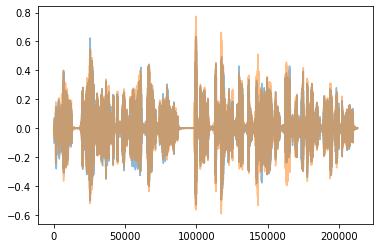

In [62]:
reconstructed_wav = vocoder.inference(batch.melspec_prediction[0:1].transpose(-1, -2)).cpu()
waveform = vocoder.inference(batch.melspec[0:1]).cpu()

plt.plot(reconstructed_wav.squeeze(), label='reconstructed', alpha=.5)
plt.plot(waveform.squeeze(), label='GT', alpha=.5)
# plt.grid()
# plt.legend()
plt.show()

In [63]:
display.display(display.Audio(reconstructed_wav, rate=22050))
display.display(display.Audio(waveform, rate=22050))

In [75]:
index = 0

waveform = dummy_batch.waveform[index][:dummy_batch.waveforn_length[index]]
durations = dummy_batch.durations[index][:dummy_batch.token_lengths[index]]

# scale by waveform domain
durations = durations * dummy_batch.waveforn_length[index]
durations = durations.cumsum(dim=0).int()

print(dummy_batch.transcript[index])
left = 0
for right, char in zip(durations[:10], dummy_batch.transcript[index]):
    print(char)
    display.display(display.Audio(waveform[left:right], rate=22050))
    left = right
    print('-' * 99)

Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
P


---------------------------------------------------------------------------------------------------
r


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
t


---------------------------------------------------------------------------------------------------
i


---------------------------------------------------------------------------------------------------
n


---------------------------------------------------------------------------------------------------
g


---------------------------------------------------------------------------------------------------
,


---------------------------------------------------------------------------------------------------
 


---------------------------------------------------------------------------------------------------
